# Applying the U-Net to real seismic data

In this notebook we will once again build the U-Net but this time instead of training we simply load in the model weights we saved after training.  We then apply the trained model to data from NCEDC stations that recorded the 2022 Ferndale earthquake.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchsummary import summary
# from torchviz import make_dot
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary

## Build the U-net

In [2]:
# Cell 2: U-Net Building Blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

class UNet1D(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[16, 32, 64, 128]):
        super().__init__()
        
        self.downs = nn.ModuleList()  # Encoder blocks (downsampling path)
        self.ups = nn.ModuleList()    # Decoder blocks (upsampling path)
    
        # ----- Encoder: Downsampling Path -----
        # Each ConvBlock halves the temporal resolution via pooling (done in forward),
        # and increases the number of feature channels.
        for feat in features:
            self.downs.append(ConvBlock(in_channels, feat))  # ConvBlock: Conv + ReLU + Conv + ReLU
            in_channels = feat  # Update in_channels for the next block
    
        # ----- Bottleneck -----
        # Deepest layer in the U-Net, connects encoder and decoder
        self.bottleneck = ConvBlock(features[-1], features[-1]*2)
    
        # ----- Decoder: Upsampling Path -----
        # Reverse features list for symmetrical decoder
        rev_feats = features[::-1]
        for feat in rev_feats:
            # First upsample (via transposed convolution)
            self.ups.append(
                nn.ConvTranspose1d(feat*2, feat, kernel_size=2, stride=2)
            )
            # Then apply ConvBlock: input has double channels due to skip connection
            self.ups.append(ConvBlock(feat*2, feat))
    
        # ----- Final Output Convolution -----
        # 1x1 convolution to map to desired output channels (e.g., P, S, noise)
        self.final_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool1d(x, kernel_size=2)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_conn = skip_connections[idx//2]
            if x.shape[-1] != skip_conn.shape[-1]:
                x = F.pad(x, (0, skip_conn.shape[-1] - x.shape[-1]))
            x = torch.cat((skip_conn, x), dim=1)
            x = self.ups[idx+1](x)
        x = self.final_conv(x)
        return F.softmax(x, dim=1)

# Load weights into the model

This cell loads the saved weights into the model.

In [3]:
model = UNet1D()
model.load_state_dict(torch.load("../Loic/model_weights.pt",weights_only=True, map_location=torch.device('cpu')))
model.eval() 

UNet1D(
  (downs): ModuleList(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(3, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (2): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (3): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU

# Load and preprocess MiniSEED waveform data

The most important thing here is to make sure that the input data is similar to the training set.  This includes insuring that the sample rates are the same and the same normalizations applied to the preprocessing steps are applie



In [4]:
# Load and preprocess MiniSEED waveform data
import numpy as np
from obspy import read, Stream, Trace

# the PNW dataset is in ENZ order, if only Z is present, we need to create dummy E and N traces
def ensure_ENZ_order(st):
    """
    Ensure a stream has channels in E, N, Z order.
    If only Z is present, create dummy E and N traces filled with zeros.
    """
    # Map component suffix to trace
    comp_map = {tr.stats.channel[-1].upper(): tr for tr in st}

    # Check for Z-only and create dummy E, N if needed
    if set(comp_map.keys()) == {"Z"}:
        z_trace = comp_map["Z"]
        npts = z_trace.stats.npts
        sampling_rate = z_trace.stats.sampling_rate
        starttime = z_trace.stats.starttime

        # Create dummy E and N traces
        e_trace = Trace(data=np.zeros(npts, dtype=np.float32), header=z_trace.stats.copy())
        n_trace = Trace(data=np.zeros(npts, dtype=np.float32), header=z_trace.stats.copy())

        e_trace.stats.channel = z_trace.stats.channel[:-1] + "E"
        n_trace.stats.channel = z_trace.stats.channel[:-1] + "N"

        # Return new stream with E, N, Z
        return Stream(traces=[e_trace, n_trace, z_trace])

    # Reorder to E, N, Z if all are present
    ordered = []
    for comp in ["E", "N", "Z"]:
        if comp in comp_map:
            ordered.append(comp_map[comp])
    return Stream(traces=ordered)


# Load the data
st = read('../data/KNEE*?H?*2022.354')
# Merge streams
st.merge(fill_value='interpolate')
# Ensure ENZ order
st = ensure_ENZ_order(st)
# TODO: Check this demeaning!
# Demean
st.detrend('demean')
# Resample to 100 Hz
for tr in st:
    if tr.stats.sampling_rate != 100:
        print(f"Resampling {tr.id} from {tr.stats.sampling_rate} Hz to {target_rate} Hz")
        tr.resample(target_rate)

# Your input data
data = np.stack([tr.data for tr in st], axis=0)  # shape: (channels, time)
chunk_size = 3001
num_channels, total_length = data.shape

# Calculate how much padding is needed
remainder = total_length % chunk_size
if remainder > 0:
    pad_width = chunk_size - remainder
    # Pad with zeros at the end along the time axis
    data = np.pad(data, ((0, 0), (0, pad_width)), mode='constant')

# Reshape to (num_chunks, 3, 3001)
num_chunks = data.shape[1] // chunk_size
chunks = data.reshape(num_channels, num_chunks, chunk_size).transpose(1, 0, 2)  # shape: (num_chunks, 3, 3001)

# Normalize each chunk independently
max_vals = np.max(np.abs(chunks), axis=2, keepdims=True)  # shape: (num_chunks, 3, 1)
normalized_chunks = np.divide(chunks, max_vals, out=np.zeros_like(chunks), where=max_vals != 0).astype(np.float32)

# Convert to torch tensor
input_tensor = torch.tensor(normalized_chunks, dtype=torch.float32, device=torch.device('cpu'))  # shape: (batch_size, 3, 3001)
print(input_tensor)

tensor([[[-0.8581, -0.8601, -0.8601,  ..., -0.9375, -0.9400, -0.9410],
         [-0.8923, -0.8940, -0.8935,  ..., -0.6638, -0.6638, -0.6642],
         [ 0.4774,  0.4787,  0.4852,  ...,  0.7491,  0.7531,  0.7504]],

        [[-0.9518, -0.9528, -0.9553,  ..., -0.9078, -0.9096, -0.9124],
         [-0.6693, -0.6688, -0.6710,  ..., -0.7935, -0.7926, -0.7930],
         [ 0.8477,  0.8477,  0.8462,  ...,  0.7309,  0.7265,  0.7250]],

        [[-0.9118, -0.9108, -0.9115,  ..., -0.8630, -0.8637, -0.8626],
         [-0.7845, -0.7841, -0.7845,  ..., -0.8413, -0.8421, -0.8434],
         [ 0.7389,  0.7314,  0.7329,  ...,  0.6713,  0.6744,  0.6834]],

        ...,

        [[-0.7507, -0.7518, -0.7496,  ..., -0.9206, -0.9202, -0.9217],
         [-0.8265, -0.8273, -0.8308,  ..., -0.8395, -0.8395, -0.8399],
         [ 0.5200,  0.5271,  0.5271,  ...,  0.6132,  0.6132,  0.6174]],

        [[-0.9040, -0.9043, -0.9040,  ..., -0.8749, -0.8782, -0.8785],
         [-0.8303, -0.8308, -0.8325,  ..., -0.8265, -0.

In [5]:
# Run inference
with torch.no_grad():
    pred = model(input_tensor).squeeze(0).cpu().numpy()  # shape: (2, T)

In [6]:
print(pred.shape)

(2880, 3, 3001)


In [7]:
# Step 1: Reshape to (2, total_length_with_padding)
input_unwrapped = input_tensor.permute(1, 0, 2).reshape(3, -1)[:, :8640000]   # Shape: (3, num_chunks * 3001)
pred_unwrapped = pred.transpose(1, 0, 2).reshape(3, -1)[:, :8640000]   # shape: (2, num_chunks * 3001)
print(input_unwrapped.shape)
print(pred_unwrapped.shape)

torch.Size([3, 8640000])
(3, 8640000)


(3, 8642880)


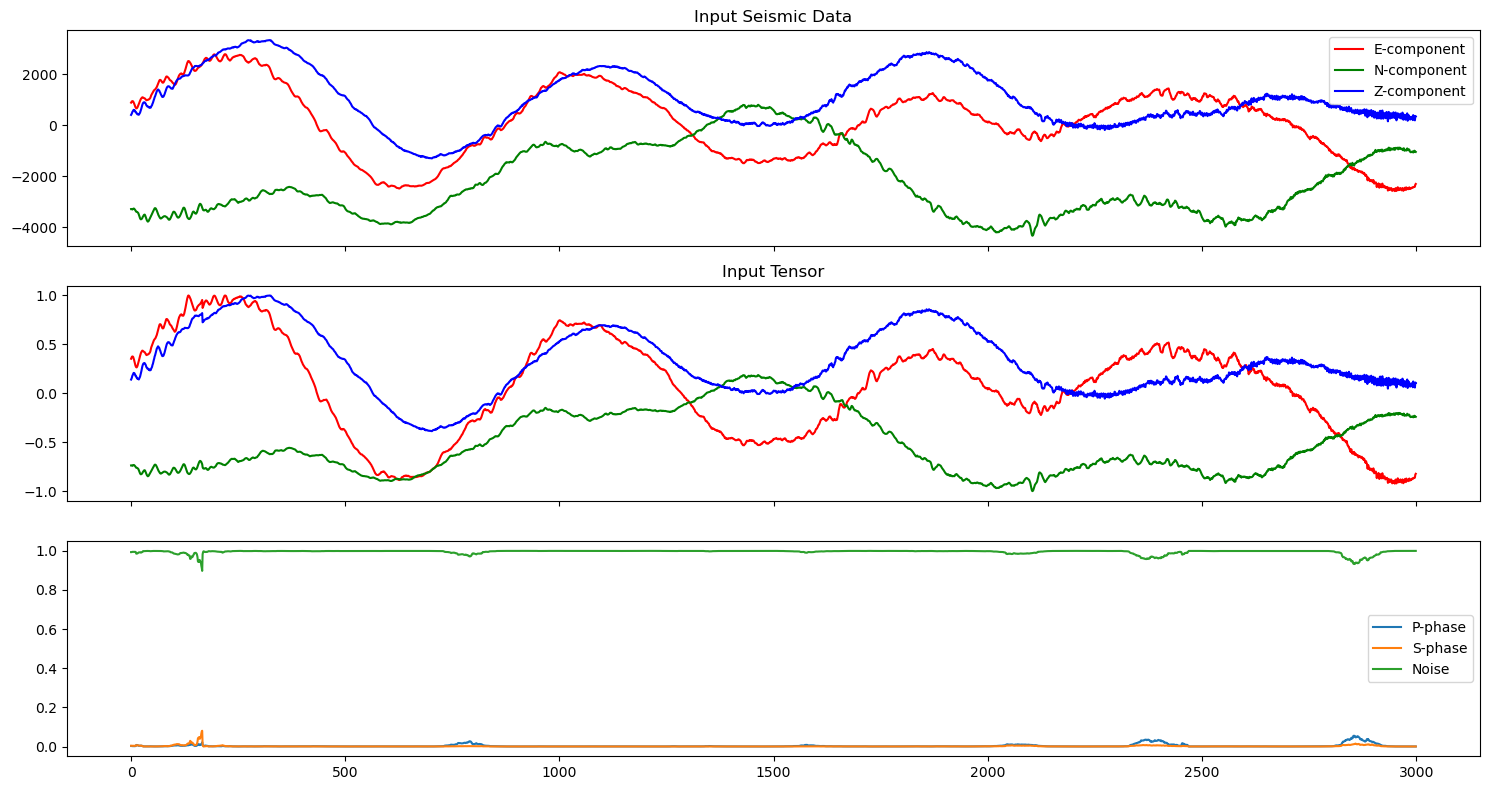

In [18]:
# Plot the predictions
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
maxind=np.where(data[2,:]==np.max(data[2,:]))[0][0]
n=50
start=maxind+n*3000
finish=start+3000
print(data.shape)

axs[0].set_title('Input Seismic Data')
axs[0].plot(data[0,start:finish], label='E-component', color='r')
axs[0].plot(data[1,start:finish], label='N-component',color='g')
axs[0].plot(data[2,start:finish], label='Z-component',color='b')
axs[0].legend()
axs[1].set_title('Input Tensor')
axs[1].plot(input_unwrapped[0,start:finish], label='E-component', color='r')
axs[1].plot(input_unwrapped[1,start:finish], label='N-component',color='g')
axs[1].plot(input_unwrapped[2,start:finish], label='Z-component',color='b')
axs[1].set_title('Input Tensor')
axs[2].plot(pred_unwrapped[0,start:finish], label='P-phase')
axs[2].plot(pred_unwrapped[1,start:finish], label='S-phase')
axs[2].plot(pred_unwrapped[2,start:finish], label='Noise')
axs[2].legend()
plt.tight_layout(); plt.show()

In [9]:
np.where(data[2,:]==np.max(data[2,:]))[0][0]  # Find the index of the maximum value in the Z-component

3808152